error is 99.00%
(1458, 1302)


<Figure size 720x432 with 0 Axes>

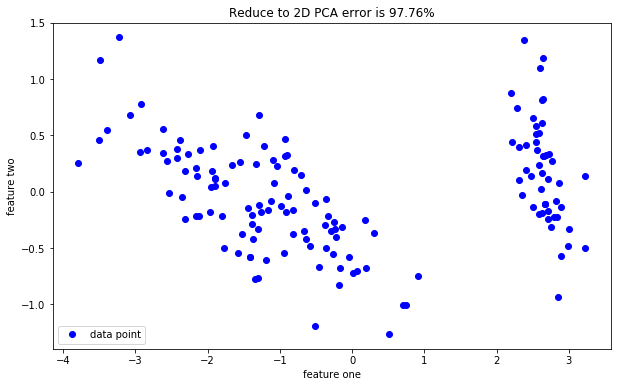

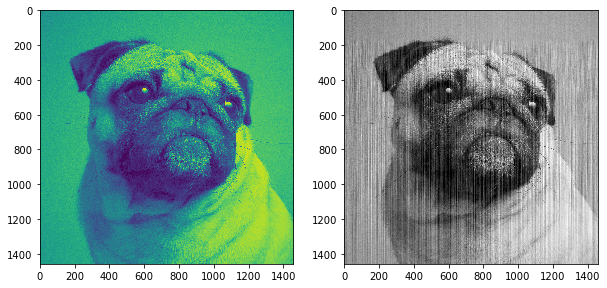

In [2]:
import numpy as np
import scipy.io#读取.mat文件
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from PIL import Image

datafile = 'data/iris.txt'
iris = np.loadtxt(datafile,delimiter=',',usecols=(0,1,2,3),unpack=True)
iris = np.transpose(iris)#是一个四维特征值的数据
#PCA应用于主成成分分析，一个应用就是数据可视化，这里我们的数据是四维数据，无法可视化
#通过PCA技术进行降维，降为3维，2维，甚至是1维，来进行可视化展示

#首先进行均值标准化,归一化
def mean_normal(x):
    for i in range(x.shape[1]):
        mean = float(np.mean(x[:,i]))
        std = np.std(x[:,i])
        #print(mean)
        for j in range(x.shape[0]):
            x[j][i]=float(x[j][i]-mean)
    return x
iris = mean_normal(iris)#得到均值为0，标准差为1的数据

#定义svd奇异值分解函数,输入是一个矩阵
def svd(x):
    #计算AAT特征值和特征向量
    eval_sigma1,evec_u = np.linalg.eigh(np.dot(x,x.T))
    #计算右奇异矩阵
    eval1_sort_idx = np.argsort(eval_sigma1)[::-1]#降序排列后，逆序输出
    #将特征值对应的特征向量排序
    eval_sigma1 = np.sort(eval_sigma1)[::-1]
    evec_u = evec_u[:,eval1_sort_idx]
    #计算奇异值矩阵的逆
    eval_sigma1 = np.sqrt(eval_sigma1)
    eval_sigma1_inv = np.linalg.inv(np.diag(eval_sigma1))
    #计算右奇异矩阵的逆
    evec_part_v = eval_sigma1_inv.dot((evec_u.T).dot(x))
    return evec_u,eval_sigma1,evec_part_v#输出三个矩阵

def pca(x,k):#将数据从n维降到k维
#计算协方差矩阵sigma,协方差矩阵是一个4x4矩阵，因为数据为四维，即nxn矩阵
    sigma = np.dot(x.T,x)/(x.shape[0]-1)
    #sigma = np.cov(x)
    u,s,v = svd(sigma)    #然后计算svd(sigma),svd 是奇异值分解
    #print(u.shape)#从n维降到k维，就取u的前k列
    Ureduce = u[:,0:k]
    nums = 0
    #print(s.shape)
    for i in range(k):
        nums=nums + s[i]
    error = float(nums/np.sum(s))
    #print(Ureduce.shape)
    return Ureduce,error#返回u和投影误差

def plt_reduce(x,k):
    #数据可视化降维为k维之后的数据
    Ureduce,error = pca(x,k)
    #print(error)
    z = np.zeros((x.shape[0],k))
    for i in range(x.shape[0]):
        z[i]=np.dot(x[i],Ureduce)
    plt.figure(figsize=(10,6))
    if(k==3):#降为三维数据
        ax = plt.axes(projection='3d')
        ax.scatter3D(z[:,0],z[:,1],z[:,2],c='g',s=8)
        ax.set_xlabel('feature one')
        ax.set_ylabel('feature two')
        ax.set_zlabel('feature three')
        ax.set_title('Reduce to 3D PCA error is {:.2f}%'.format(error*100))
        #plt.title('Reduce to 3D')
        #plt.show()
    elif (k==2):#降为二维数据
        plt.figure(figsize=(10,6))
        plt.plot(z[:,0],z[:,1],'bo',label='data point')
        plt.xlabel('feature one')
        plt.ylabel('feature two')
        plt.title('Reduce to 2D PCA error is {:.2f}%'.format(error*100))
        plt.legend()
    elif (k==1):#降为一维数据
        plt.figure(figsize=(10,8))
        plt.plot(range(z.shape[0]),z[:,0],'ro',label='data point')
        plt.xlabel('numbers')
        plt.ylabel('feature one')
        plt.title('Reduce to 1D PCA error is {:.2f}%'.format(error*100))
        plt.legend()
    else:
        print('error is {:.2f}%'.format(error*100))
    return z,Ureduce
z,u_reduce = plt_reduce(iris,2)
#print(z.shape)
#print(u_reduce.shape)

def get_error(x,k):
    Ureduce,error = pca(x,k)
    return error
#编写压缩重现函数
def review(z,u):
    X_approx = np.zeros((z.shape[0],u.shape[0]))
    for i in range(z.shape[0]):
        X_approx[i]=np.dot(z[i],u.T)
    return X_approx

xapprox = review(z,u_reduce)
#print(xapprox.shape)

#读入图像数据，人脸数据
dataface = 'data/test1.jpg'
img1 = Image.open(dataface).convert('L')
img = np.array(Image.open(dataface).convert('L')).reshape((1458,1458))
#print(img.shape)
img_arr = np.asarray(img)
#print(img_arr.shape)

#k_min = loop(img_arr,0.99)
#print(k_min)

#进行pca压缩
new_arr,ur = plt_reduce(img_arr,1302)
print(new_arr.shape)
new_img= Image.fromarray(new_arr)
#plt.subplot(2,2,1)
#plt.imshow(new_img)

#寻找最小的k满足条件误差阈值
def loop(x,threshold):
    k=x.shape[1]-1
    while(get_error(x,k)>threshold):
        k=k-1
        print(k)
    return k


#解压缩
updatex = review(new_arr,ur)
up_img = Image.fromarray(updatex)
plt.subplot(1,2,2)
plt.imshow(up_img)
plt.subplot(1,2,1)
plt.imshow(img1)